## SIT796 Reinforcement Learning

High Distinction Task 8.1 - Practical Reinforcement Learning  
**Angus Maiden** | ID 220595465

This task implements and evaluates a method of reinforcement learning presented in the paper *DQN with model-based exploration: efficient learning on environments with sparse rewards* (Zhen Gou & Liu 2019).

### Construct a class with all the required functions.  
The comments in this code reference the relevant sections of the pseudocode from the paper.

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from scipy.stats import multivariate_normal
from collections import deque

class DQN:
    def __init__(self, env):
        
        self.env = env
        self.state_shape = env.observation_space.shape
        self.action_size = env.action_space.n
        
        # Hyperparameters for DQN with Model-Based Exploration (Mountain Car).
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.Q_learning_rate = 0.05
        self.D_learning_rate = 0.02
        self.Q_batch_size = 16
        self.D_batch_size = 64
        self.D_memory_size = 50
        self.initial_explore = False
        
        # Initalise Q network with random weights θ.
        self.model = self.create_Q_model()
        
        # Initalise target Q network with random weights θ' = θ.
        self.target_model = self.create_Q_model()
        
        # Initalise D network with random weights θ_D.
        self.dynamics_model = self.create_D_model()
        
    
    # Initalise Q network with random weights θ.
    def create_Q_model(self):
        
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_shape[0], activation='relu'))
        model.add(Dense(self.action_size))
        model.compile(loss='mean_squared_error',
                      optimizer=RMSprop(learning_rate=self.Q_learning_rate, clipvalue = 1))
        return model
    
    # Initalise D network with random weights θ_D.
    def create_D_model(self):
        
        model = Sequential()
        model.add(Dense(24, input_dim = 3, activation='relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.state_shape[0]))
        model.compile(loss='mean_squared_error',
                      optimizer=RMSprop(learning_rate=self.D_learning_rate, clipvalue = 1))
        return model
        
    # Fit a multivariate normal distribution to the mean and covariance of recent states.
    def D_model(self, D_states):
        
        D_mean = np.mean(D_states, axis = 0)
        D_cov = np.cov(D_states, rowvar = False)
        D_model = multivariate_normal(cov = D_cov, mean = D_mean)
        return D_model
    
    # Action selection for traditional DQN.
    def Q_act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        
        # Random selection with probability epsilon.
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # If not exploring, greedy action selection.
        return np.argmax(self.model.predict(state.reshape(1,2))[0])
    
    # Enable or disable initial exploration-only flag.
    def D_explore(self, explore=False):
        
        if explore:
            self.initial_explore = True
            return True
        else:
            return False

    # Action selection for DQN with Model-based exploration.
    def D_act(self, state):
        
        # Epsilon decay (after initial exploration).
        if self.initial_explore == False:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon_min, self.epsilon)
        
        # Explore with probability epsilon, or on initial exploration-only steps.
        if (np.random.random() < self.epsilon) or (self.initial_explore == True):
            
            # If not enough memory, random selection with probability epsilon.
            if len(self.memory) <= self.D_memory_size:
                return self.env.action_space.sample(), True

            # Model-based exploration.
            else:
                # Retrieve the last 50 states visited from M and store in F.
                D_memory = itertools.islice(self.memory,
                                            len(self.memory) - self.D_memory_size,
                                            len(self.memory))
                
                D_states, actions, rewards, new_states, dones = zip(*D_memory)
                
                # Compute mean μ_F and covariance Σ_F. Fit a multivariate normal
                # distribution with these parameters to the last 50 states.
                D_model = self.D_model(D_states)
                
                predicted_states = []
                
                # Iterate over the possible actions at the current state.
                for action in range(self.action_size):
                    
                    # Predict the next state using trained D network.
                    X = np.hstack([state, action])
                    y_pred = self.dynamics_model.predict(X.reshape(1,3))[0]
                    predicted_states.append(y_pred)

                # Pick a = argmin_a[N(D(s,a,θ_D)|μ_F,Σ_F))]
                return np.argmin(D_model.pdf(predicted_states)), True
        
        # If not exploring, greedy action selection.
        return np.argmax(self.model.predict(state.reshape(1,2))[0]), False
    
    # Store transition (s, a, r, s') in M.
    def remember(self, state, action, reward, new_state, done):
        
        self.memory.append([state, action, reward, new_state, done])
    
    # Execute main part of the code (original DQN algorithm).
    def Q_replay(self):
        
        if len(self.memory) < self.Q_batch_size: 
            return 0
        
        # Sample a batch of transitions uniformly (s, a, r, s') from M.
        Q_samples = random.sample(self.memory, self.Q_batch_size)
        Q_X, Q_y = [], []
        
        # Set y = r + γ*max_a[Q'(s,a;θ)] if episode not done, else y = r.
        for sample in Q_samples:

            state, action, reward, new_state, done = sample
            y = self.target_model.predict(state.reshape(1,2))[0]

            if done:
                y[action] = reward
            
            else:
                y[action] = reward + self.gamma * max(self.target_model.predict(new_state.reshape(1,2))[0])
            
            Q_X.append(state)
            Q_y.append(y)
        
        # Perform gradient descent on Q with respect to θ on (y - Q(s,a;θ))^2.
        Q_history = self.model.fit(np.array(Q_X),
                                   np.array(Q_y),
                                   epochs = 1,
                                   verbose = 0)
        
        # Record and return the loss.
        loss = Q_history.history['loss'][0]
        return loss
    
    # Execute main part of the code (DQN with model based exploration).
    def D_replay(self):
        
        if len(self.memory) <= self.D_batch_size: 
            return 0, 0
        
        # Sample a batch of transitions uniformly (s, a, r, s') from M.
        Q_samples = random.sample(self.memory, self.Q_batch_size)
        Q_X, Q_y = [], []
        
        # Set y = r + γ*max_a[Q'(s,a;θ)] if episode not done, else y = r.
        for sample in Q_samples:

            state, action, reward, new_state, done = sample
            y = self.target_model.predict(state.reshape(1,2))[0]
            
            if done:
                y[action] = reward
            
            else:
                y[action] = reward + self.gamma * max(self.target_model.predict(new_state.reshape(1,2))[0])
            
            Q_X.append(state)
            Q_y.append(y)
        
        # Perform gradient descent on Q with respect to θ on (y - Q(s,a;θ))^2.
        Q_history = self.model.fit(np.array(Q_X),
                                   np.array(Q_y),
                                   epochs = 1,
                                   verbose = 0)
        
        # Record loss.
        Q_loss = Q_history.history['loss'][0]
        
        # Sample a batch of transitions uniformly (s, a, r, s') from M. D network uses different batch size.
        D_samples = random.sample(self.memory, self.D_batch_size)
        D_X, D_y = [], []
        
        # Process sample data for training in D network.
        for sample in D_samples:
            state, action, reward, new_state, done = sample
            
            X = np.hstack([state, action])
            y = new_state

            D_X.append(X)
            D_y.append(y)
        
        # Perform gradient descent on D with respect to θ on (s' - D(s,a;θ_D))^2.
        D_history = self.dynamics_model.fit(np.array(D_X),
                                            np.array(D_y),
                                            epochs = 1,
                                            verbose = 0)
        
        # Record the loss.
        D_loss = D_history.history['loss'][0]
        
        # Return Q network and D network losses.
        return Q_loss, D_loss
    
    # Update Target Q Network with Q Network values (Q' = Q).
    def target_train(self):

        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()

        for i in range(len(target_weights)):
            target_weights[i] = weights[i]
        
        self.target_model.set_weights(target_weights)

In [2]:
# Setup the environment and initial variables.
env = gym.make('MountainCar-v0')
D_agent = DQN(env=env)
D_losses = []
Q_losses = []
D_episode_rewards_list = []
D_finished_list = []
episodes  = 100
num_steps = 200
updateTargetNetwork = 8

### Run DQN With Model-Based Exploration (Initial exploration run of 10,000 steps).

In [3]:
# Set initial exploration flag.
explore = D_agent.D_explore(True)

for episode in range(int(10000/num_steps)):
    cur_state = env.reset()
    done = False
    total_episode_reward = 0
    for step in range(num_steps):
        
        # Execute a and observe reward r and new state s'.
        action, explored = D_agent.D_act(cur_state)
        new_state, reward, done, _ = env.step(action)
        
        # Store transition (s, a, r, s') in M.
        D_agent.remember(cur_state, action, reward, new_state, done)

        # Tally the reward.
        total_episode_reward += reward
        
        # Perform gradient descent on Q and D using experience replay.
        Q_loss, D_loss = D_agent.D_replay()

        # Log the training as output.
        print(f'\rEpisode: {episode+1}/{episodes} | Initial Exploration: {explore} '
              f'|Step: {step+1} | Rewards: {total_episode_reward} | Q Loss: {Q_loss:.4f} '
              f'| D Loss: {D_loss:.4f}', end='')
        
        # Every C steps set Q' = Q.
        if  step % updateTargetNetwork == 0:
            D_agent.target_train()
        
        # Update environment state.
        cur_state = new_state
        
        # Exit loop if episode finished.
        if done:
            break
    
    # Tally rewards and gradient descent losses for each episode.
    D_episode_rewards_list.append(total_episode_reward)
    D_losses.append(D_loss)
    Q_losses.append(Q_loss)
    
    # If the goal was reached, record it and keep training.
    if step >= 199:
        D_finished_list.append(0)
        if episode+1 >= 100:
            print(f'\nFailed to reach goal. Reached 100 episodes, stopping training.')
        else:
            print(f'\nFailed to reach goal. Continuing training...')
    else:
        D_finished_list.append(1)
        if episode+1 >= 100:
            print(f'\nReached goal in last episode. Reached 100 episodes, stopping training.')
        else:
            print(f'\nReached goal in last episode. Continuing training...')

Episode: 1/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.1943 | D Loss: 0.0008
Failed to reach goal. Continuing training...
Episode: 2/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.1764 | D Loss: 0.0019
Failed to reach goal. Continuing training...
Episode: 3/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.1375 | D Loss: 0.0001
Failed to reach goal. Continuing training...
Episode: 4/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.0887 | D Loss: 0.0021
Failed to reach goal. Continuing training...
Episode: 5/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.1983 | D Loss: 0.0008
Failed to reach goal. Continuing training...
Episode: 6/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.0607 | D Loss: 0.0005
Failed to reach goal. Continuing training...
Episode: 7/100 | Initial Exploration: True |Step: 200 | Rewards: -200.0 | Q Loss: 0.8692 | D L

<function matplotlib.pyplot.show(close=None, block=None)>

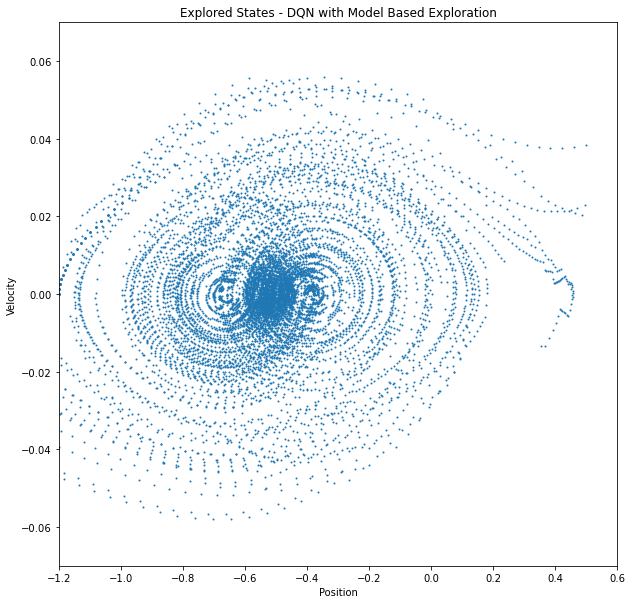

In [4]:
# Make a scatterplot of the exploration results.
expl_states, expl_actions, expl_rewards, expl_new_states, expl_dones = zip(*D_agent.memory)
expl_states_array = np.array(expl_states)
plt.figure(figsize=(10,10))
plt.scatter(expl_states_array[:,0], expl_states_array[:,1], s = 1)
plt.title('Explored States - DQN with Model Based Exploration')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim([-1.2, 0.6])
plt.ylim([-0.07, 0.07])
plt.show

In [11]:
# Create a run of 10,000 purely random steps.
R_memory = []
R_state = env.reset()
for step in range(10000):
    action = env.action_space.sample()
    R_state, reward, done, _ = env.step(action)
    R_memory.append(R_state)

<function matplotlib.pyplot.show(close=None, block=None)>

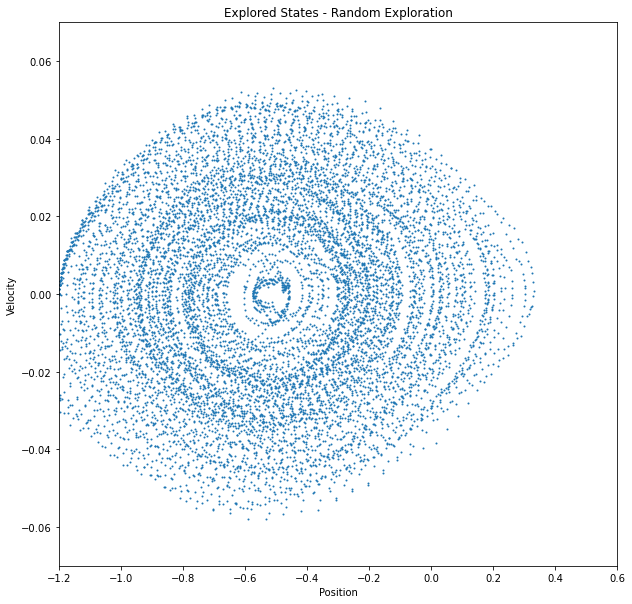

In [12]:
# Make a scatterplot of the random exploration.
R_states_array = np.array(R_memory)
plt.figure(figsize=(10,10))
plt.scatter(R_states_array[:,0], R_states_array[:,1], s = 1)
plt.title('Explored States - Random Exploration')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim([-1.2, 0.6])
plt.ylim([-0.07, 0.07])
plt.show

### Continue training, using model-based exploration with probability epsilon, otherwise exploiting.

In [13]:
# Set initial exploration flag.
explore = D_agent.D_explore(False)

for episode in range(int(episodes-10000/num_steps)):
    cur_state = env.reset()
    done = False
    total_episode_reward = 0
    for step in range(num_steps):

        # Execute a and observe reward r and new state s'.
        action, explored = D_agent.D_act(cur_state)
        new_state, reward, done, _ = env.step(action)

        # Store transition (s, a, r, s') in M.
        D_agent.remember(cur_state, action, reward, new_state, done)

        # Tally the reward.
        total_episode_reward += reward

        # Perform gradient descent on Q and D using experience replay.
        Q_loss, D_loss = D_agent.D_replay()

        # Log the training as output.
        print(f'\rEpisode: {episode+51}/{episodes} |  Initial Exploration: {explore} '
              f'| Step: {step+1} | Rewards: {total_episode_reward} | Q Loss: {Q_loss:.4f} '
              f'| D Loss: {D_loss:.4f}', end='')
        
        # Every C steps set Q' = Q.
        if  step % updateTargetNetwork == 0:
            D_agent.target_train()
        
        # Update environment state.
        cur_state = new_state
        
        # Exit loop if episode finished.
        if done:
            break
    
    # Tally rewards and gradient descent losses for each episode.
    D_episode_rewards_list.append(total_episode_reward)
    D_losses.append(D_loss)
    Q_losses.append(Q_loss)

    # If the goal was reached, record it and keep training.
    if step >= 199:
        D_finished_list.append(0)
        if episode+51 >= 100:
            print(f'\nFailed to reach goal. Reached 100 episodes, stopping training.')
        else:
            print(f'\nFailed to reach goal. Continuing training...')
    else:
        D_finished_list.append(1)
        if episode+51 >= 100:
            print(f'\nReached goal in last episode. Reached 100 episodes, stopping training.')
        else:
            print(f'\nReached goal in last episode. Continuing training...')

Episode: 51/100 |  Initial Exploration: False | Step: 200 | Rewards: -200.0 | Q Loss: 2.5443 | D Loss: 0.000646
Failed to reach goal. Continuing training...
Episode: 52/100 |  Initial Exploration: False | Step: 200 | Rewards: -200.0 | Q Loss: 4.4764 | D Loss: 0.001773
Failed to reach goal. Continuing training...
Episode: 53/100 |  Initial Exploration: False | Step: 200 | Rewards: -200.0 | Q Loss: 1.9619 | D Loss: 0.00037
Failed to reach goal. Continuing training...
Episode: 54/100 |  Initial Exploration: False | Step: 200 | Rewards: -200.0 | Q Loss: 0.3223 | D Loss: 0.000224
Failed to reach goal. Continuing training...
Episode: 55/100 |  Initial Exploration: False | Step: 200 | Rewards: -200.0 | Q Loss: 0.0983 | D Loss: 0.000459
Failed to reach goal. Continuing training...
Episode: 56/100 |  Initial Exploration: False | Step: 200 | Rewards: -200.0 | Q Loss: 2.1836 | D Loss: 0.0002007
Failed to reach goal. Continuing training...
Episode: 57/100 |  Initial Exploration: False | Step: 200 

<function matplotlib.pyplot.show(close=None, block=None)>

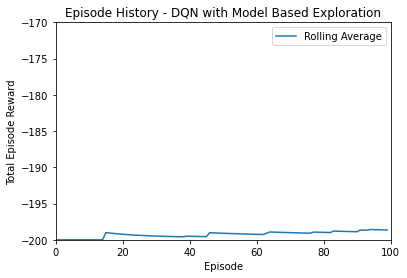

In [21]:
# Plot the results.
rolling_D_episode_rewards_list = pd.DataFrame(D_episode_rewards_list).rolling(100, min_periods = 1).mean()
plt.plot(rolling_D_episode_rewards_list)
plt.title('Episode History - DQN with Model Based Exploration')
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.ylim([-200, -170])
plt.xlim([0,100])
plt.legend(['Rolling Average'])
plt.show

### Compare results with original DQN.

In [22]:
# Setup the initial variables.
Q_agent = DQN(env=env)
losses = []
episode_rewards_list = []
finished_list = []
episodes  = 100
num_steps = 200
updateTargetNetwork = 8

for episode in range(episodes):

    cur_state = env.reset()
    total_episode_reward = 0
    done = False

    for step in range(num_steps):

        # Execute a and observe reward r and new state s'.
        action = Q_agent.Q_act(cur_state)
        new_state, reward, done, _ = env.step(action)

        # Store transition (s, a, r, s') in M.
        Q_agent.remember(cur_state, action, reward, new_state, done)
        
        # Perform gradient descent on Q and D using experience replay.
        loss = Q_agent.Q_replay()

        # Tally the reward.
        total_episode_reward += reward

        # Log the training as output.
        print(f'\rEpisode: {episode+1}/{episodes} | Step: {step+1} '
              f'| Rewards: {total_episode_reward} | Loss: {loss:.4f}', end='')
        
        # Every C steps set Q' = Q.
        if  step % updateTargetNetwork == 0:
            Q_agent.target_train()
        
        # Update environment state.
        cur_state = new_state
        
        # Exit loop if episode finished.
        if done:
            break
    
    # Tally rewards and gradient descent losses for each episode.
    losses.append(loss)
    episode_rewards_list.append(total_episode_reward)

    # If the goal was reached, record it and keep training.
    if step >= 199:
        D_finished_list.append(0)
        if episode+1 >= 100:
            print(f'\nFailed to reach goal. Reached 100 episodes, stopping training.')
        else:
            print(f'\nFailed to reach goal. Continuing training...')
    else:
        D_finished_list.append(1)
        if episode+1 >= 100:
            print(f'\nReached goal in last episode. Reached 100 episodes, stopping training.')
        else:
            print(f'\nReached goal in last episode. Continuing training...')

Episode: 1/100 | Step: 200 | Rewards: -200.0 | Loss: 0.2128
Failed to reach goal. Continuing training...
Episode: 2/100 | Step: 200 | Rewards: -200.0 | Loss: 0.3240
Failed to reach goal. Continuing training...
Episode: 3/100 | Step: 200 | Rewards: -200.0 | Loss: 0.2583
Failed to reach goal. Continuing training...
Episode: 4/100 | Step: 200 | Rewards: -200.0 | Loss: 0.3290
Failed to reach goal. Continuing training...
Episode: 5/100 | Step: 200 | Rewards: -200.0 | Loss: 0.3516
Failed to reach goal. Continuing training...
Episode: 6/100 | Step: 200 | Rewards: -200.0 | Loss: 0.2868
Failed to reach goal. Continuing training...
Episode: 7/100 | Step: 200 | Rewards: -200.0 | Loss: 0.2302
Failed to reach goal. Continuing training...
Episode: 8/100 | Step: 200 | Rewards: -200.0 | Loss: 0.3717
Failed to reach goal. Continuing training...
Episode: 9/100 | Step: 200 | Rewards: -200.0 | Loss: 0.1793
Failed to reach goal. Continuing training...
Episode: 10/100 | Step: 200 | Rewards: -200.0 | Loss: 3

<function matplotlib.pyplot.show>

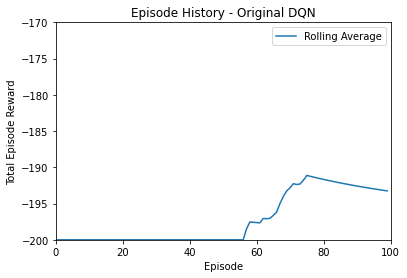

In [23]:
# Plot the results as a moving average (to see trends).
rolling_episode_rewards_list = pd.DataFrame(episode_rewards_list).rolling(100, min_periods = 1).mean()
plt.plot(rolling_episode_rewards_list)
plt.title('Episode History - Original DQN')
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.ylim([-200, -170])
plt.xlim([0,100])
plt.legend(['Rolling Average'])
plt.show